# Important: Modify the pynvrtc package as described in the following:
https://github.com/loicland/superpoint_graph/issues/43#issuecomment-406928322

# Imports

In [1]:
from torchqrnn import QRNN, QRNNLayer

In [59]:
import numpy as np

from pprint import pprint
from torchtext import data
from torchtext import datasets
from torchtext.vocab import Vectors, GloVe

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, RNN, LSTM, GRU, Conv1d
from torch.nn.functional import softmax, relu

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

import warnings
warnings.filterwarnings('ignore')

DATA_DIRECTORY = "data/"

In [3]:
# torch.backends.cudnn.enabled=False

In [4]:
use_cuda = torch.cuda.is_available()
def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x

def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

print(use_cuda)

True


In [5]:
id_seqs = {str(i):[] for i in range(6)}
with open(DATA_DIRECTORY+'train_filtered.txt','r') as fIn : 
    for line in fIn :
        line = line.split(',')
        id_seqs[line[1].strip()].append(line[0])

In [6]:
print(len(id_seqs['1'][0]))
print(len(id_seqs['3']))

1631
2874


In [7]:
import random

In [8]:
seq_0 = random.sample(id_seqs['0'],200)
seq_3 = random.sample(id_seqs['3'],200)

In [9]:
with open('train_mini_0and3.txt','w') as fOut : 
    for seq in seq_0 : 
        fOut.write(seq + "," + "0\n")
    for seq in seq_3 : 
        fOut.write(seq + "," + "3\n") 

## taking only 500 first nucleotids

In [12]:
with open(DATA_DIRECTORY+'train_filtered.txt','r') as fIn : 
    with open(DATA_DIRECTORY+'train_filtered_reduced.txt','w') as fOut : 
        for line in fIn : 
            line = line.split(',')
            fOut.write(line[0][:1000] + "," + line[1])

In [13]:
with open(DATA_DIRECTORY+'test_filtered.txt','r') as fIn : 
    with open(DATA_DIRECTORY+'test_filtered_reduced.txt','w') as fOut : 
        for line in fIn : 
            line = line.split(',')
            fOut.write(line[0][:1000] + "," + line[1])

In [14]:
with open(DATA_DIRECTORY+'val_filtered.txt','r') as fIn : 
    with open(DATA_DIRECTORY+'val_filtered_reduced.txt','w') as fOut : 
        for line in fIn : 
            line = line.split(',')
            fOut.write(line[0][:1000] + "," + line[1])

In [15]:
dic = {'0':0, '1':0, '2':0, '3':0, '4':0, '5':0}
with open(DATA_DIRECTORY+'val_filtered.txt','r') as fIn : 
    for line in fIn : 
        line = line.split(',')
        dic[line[1].strip()] +=1 

In [16]:
dic

{'0': 497, '1': 788, '2': 114, '3': 410, '4': 229, '5': 46}

# Torchtext dataloader 

In [17]:
#Initialize the two fields: Sequence and Class
SEQ = data.Field(sequential=True,include_lengths=True, unk_token='N')
LABEL = data.Field(sequential=False, unk_token='1') # is_target = True ?

#train_set, validation_set, test_set = data.TabularDataset.splits(path='',
#                                                                 train='train_mini_0and3.txt',
#                                                                 validation='train_mini_0and3.txt',
#                                                                 test='train_mini_0and3.txt', 
#                                                                 format = 'csv',
#                                                                 fields=[('sequence', SEQ), ('label', LABEL)])

train_set, validation_set, test_set = data.TabularDataset.splits(path='',
                                                                 train=DATA_DIRECTORY+'train_filtered_reduced.txt',
                                                                 validation=DATA_DIRECTORY+'val_filtered_reduced.txt',
                                                                 test=DATA_DIRECTORY+'test_filtered_reduced.txt', 
                                                                 format = 'csv',
                                                                 fields=[('sequence', SEQ), ('label', LABEL)])

(array([1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 9.0000e+00,
        1.4000e+01, 1.3000e+01, 2.1000e+01, 3.0000e+01, 1.4521e+04]),
 array([123. , 160.7, 198.4, 236.1, 273.8, 311.5, 349.2, 386.9, 424.6,
        462.3, 500. ]),
 <a list of 10 Patch objects>)

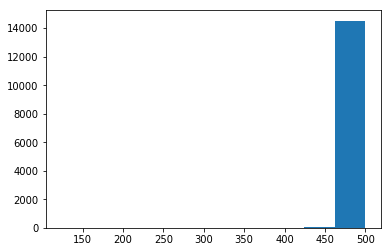

In [18]:
L = [len(train_set[i].sequence) for i in range(len(train_set))]
plt.hist(L)


In [19]:
print('train_set.fields:', list(train_set.fields.keys()))
print('validation_set.fields:', list(validation_set.fields.keys()))
print('test_set.fields:', list(test_set.fields.keys()))
print()
print('size of training set', len(train_set))
print('size of validation set', len(validation_set))
print()
print('content of first training sample:')
print(vars(train_set[0]))

train_set.fields: ['sequence', 'label']
validation_set.fields: ['sequence', 'label']
test_set.fields: ['sequence', 'label']

size of training set 14611
size of validation set 2084

content of first training sample:
{'sequence': ['T', 'G', 'G', 'G', 'C', 'T', 'C', 'C', 'C', 'G', 'C', 'C', 'T', 'C', 'A', 'G', 'T', 'G', 'C', 'G', 'C', 'A', 'T', 'G', 'T', 'T', 'C', 'A', 'C', 'T', 'G', 'G', 'G', 'C', 'G', 'T', 'C', 'T', 'T', 'C', 'T', 'G', 'C', 'C', 'C', 'G', 'G', 'C', 'C', 'C', 'C', 'T', 'T', 'C', 'G', 'C', 'C', 'C', 'A', 'C', 'G', 'T', 'G', 'A', 'A', 'G', 'A', 'A', 'C', 'G', 'C', 'C', 'A', 'G', 'G', 'G', 'A', 'G', 'C', 'T', 'G', 'T', 'G', 'A', 'G', 'G', 'C', 'A', 'G', 'T', 'G', 'C', 'T', 'G', 'T', 'G', 'T', 'G', 'G', 'T', 'T', 'C', 'C', 'T', 'G', 'C', 'C', 'G', 'T', 'C', 'C', 'G', 'G', 'A', 'C', 'T', 'C', 'T', 'T', 'T', 'T', 'T', 'C', 'C', 'T', 'C', 'T', 'A', 'C', 'T', 'G', 'A', 'G', 'A', 'T', 'T', 'C', 'A', 'T', 'C', 'T', 'G', 'T', 'G', 'T', 'G', 'A', 'A', 'A', 'T', 'A', 'T', 'G', 'A', '

In [20]:
# build the vocabularies
SEQ.build_vocab(train_set) #NO unknows 
LABEL.build_vocab(train_set)

In [21]:
print('Text fields:')
print(' size of vocabulary:', len(SEQ.vocab))
# print(" vocabulary's embedding dimension:", SEQ.vocab.vectors.size())
print(' no. times the "N" appear in the dataset:', SEQ.vocab.freqs['N'])
print(" list of vocabulary (int-to-str):", SEQ.vocab.itos)
print(" list of vocabulary (str-to-int):", dict(SEQ.vocab.stoi))
print(SEQ.vocab.freqs)
print('\nLabel fields:')
#print('keys of LABEL.vocab:', list(LABEL.vocab.__dict__.keys()))
print(" list of vocabulary (int-to-str):", LABEL.vocab.itos)
print(" list of vocabulary (str-to-int):", dict(LABEL.vocab.stoi))
print(LABEL.vocab.freqs)

Text fields:
 size of vocabulary: 6
 no. times the "N" appear in the dataset: 57
 list of vocabulary (int-to-str): ['N', '<pad>', 'G', 'C', 'A', 'T']
 list of vocabulary (str-to-int): {'N': 0, '<pad>': 1, 'G': 2, 'C': 3, 'A': 4, 'T': 5}
Counter({'G': 2143314, 'C': 2026764, 'A': 1629881, 'T': 1494463, 'N': 57})

Label fields:
 list of vocabulary (int-to-str): ['1', '0', '3', '4', '2', '5']
 list of vocabulary (str-to-int): {'1': 0, '0': 1, '3': 2, '4': 3, '2': 4, '5': 5}
Counter({'1': 5531, '0': 3486, '3': 2874, '4': 1578, '2': 814, '5': 328})


In [22]:

weight = [i/sum(dic.values()) for i in dic.values()]
weight_square = [i**2 for i in weight]
weight_square = torch.FloatTensor(weight_square).cuda()
weight_square = 1 - weight_square/sum(weight_square)


final_weights = torch.FloatTensor([weight_square[int(i)] for i in LABEL.vocab.itos]).cuda()
print(final_weights)

tensor([0.4373, 0.7762, 0.8477, 0.9525, 0.9882, 0.9981], device='cuda:0')


In [23]:
[i/sum(dic.values()) for i in dic.values()]

[0.23848368522072938,
 0.3781190019193858,
 0.05470249520153551,
 0.1967370441458733,
 0.10988483685220729,
 0.022072936660268713]

In [24]:
BATCH_SIZE = 16

train_iter = data.BucketIterator(train_set,
                                 batch_size=BATCH_SIZE, 
                                 device=torch.device("cuda:0" if use_cuda else "cpu"),
                                 sort_key=lambda x: len(x.sequence), #Sorting within the batch
                                 sort = True,
                                 repeat = False
                                )

validation_iter = data.BucketIterator(validation_set,
                                 batch_size=BATCH_SIZE, 
                                 device=torch.device("cuda:0" if use_cuda else "cpu"),
                                 sort_key=lambda x: len(x.sequence), #Sorting within the batch
                                sort = True,
                                repeat = False
                                )


In [25]:
for i in train_iter : 
    print(i.label)

tensor([4, 5, 5, 4, 4, 4, 4, 4, 1, 4, 5, 4, 4, 1, 4, 2], device='cuda:0')
tensor([4, 2, 4, 4, 0, 5, 2, 5, 5, 0, 4, 4, 5, 4, 4, 4], device='cuda:0')
tensor([4, 4, 3, 5, 0, 0, 4, 0, 4, 4, 1, 2, 4, 2, 4, 4], device='cuda:0')
tensor([4, 4, 2, 1, 2, 2, 4, 4, 0, 2, 0, 4, 4, 4, 2, 2], device='cuda:0')
tensor([2, 3, 4, 0, 0, 4, 4, 2, 4, 4, 0, 0, 4, 0, 4, 2], device='cuda:0')
tensor([4, 2, 4, 4, 4, 4, 2, 0, 1, 4, 2, 2, 4, 2, 4, 4], device='cuda:0')
tensor([4, 5, 3, 3, 5, 2, 2, 2, 2, 4, 0, 2, 2, 4, 4, 3], device='cuda:0')
tensor([0, 0, 2, 2, 2, 2, 1, 2, 4, 4, 4, 4, 1, 2, 4, 4], device='cuda:0')
tensor([0, 0, 0, 0, 1, 1, 0, 0, 4, 4, 4, 4, 4, 0, 0, 0], device='cuda:0')
tensor([2, 2, 2, 2, 2, 1, 1, 3, 2, 2, 2, 3, 0, 0, 0, 0], device='cuda:0')
tensor([4, 0, 0, 1, 1, 1, 0, 2, 0, 0, 0, 1, 1, 1, 1, 2], device='cuda:0')
tensor([0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
tensor([1, 1, 1, 3, 0, 1, 1, 2, 2, 2, 2, 0, 4, 1, 1, 0], device='cuda:0')
tensor([2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 

tensor([0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 1], device='cuda:0')
tensor([1, 1, 1, 1, 0, 1, 1, 1, 3, 1, 1, 1, 1, 1, 0, 4], device='cuda:0')
tensor([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1], device='cuda:0')
tensor([0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 4, 4, 4], device='cuda:0')
tensor([3, 3, 3, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
tensor([0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 3, 3, 3, 3], device='cuda:0')
tensor([0, 1, 3, 0, 3, 4, 0, 0, 0, 4, 1, 1, 1, 1, 1, 4], device='cuda:0')
tensor([1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1, 1, 1, 0, 0, 4, 4, 4, 1, 1, 1, 0, 1], device='cuda:0')
tensor([1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1], device='cuda:0')
tensor([3, 3, 0, 2, 2, 2, 0, 1, 0, 1, 1, 1, 1, 0, 4, 1], device='cuda:0')
tensor([1, 1, 1, 1, 1, 1, 0, 3, 3, 3, 0, 0, 3, 3, 3, 1], device='cuda:0')
tensor([1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 

tensor([0, 2, 2, 0, 0, 0, 0, 3, 3, 3, 3, 2, 3, 3, 0, 0], device='cuda:0')
tensor([3, 3, 0, 0, 3, 2, 0, 2, 2, 2, 3, 1, 1, 2, 0, 0], device='cuda:0')
tensor([0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3, 2, 3], device='cuda:0')
tensor([0, 2, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2], device='cuda:0')
tensor([2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 3, 3, 2], device='cuda:0')
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
tensor([0, 0, 0, 0, 3, 3, 3, 0, 0, 0, 3, 3, 3, 3, 3, 3], device='cuda:0')
tensor([0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
tensor([0, 2, 2, 2, 2, 2, 3, 2, 2, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([0, 2, 2, 2, 0, 0, 0, 3, 3, 1, 1, 1, 0, 2, 2, 0], device='cuda:0')
tensor([2, 2, 2, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 0, 2, 2, 4, 4, 1, 0, 0, 0, 0, 2, 2, 2], device='cuda:0')
tensor([0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 

tensor([1, 1, 1, 1, 3, 2, 2, 0, 4, 2, 2, 2, 0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
tensor([0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0], device='cuda:0')
tensor([2, 2, 2, 2, 2, 0, 0, 0, 1, 2, 2, 0, 2, 2, 0, 0], device='cuda:0')
tensor([0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 1, 0, 0, 3, 2], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 3, 0, 0, 0, 2, 1, 1, 1, 1, 1, 0, 0, 0], device='cuda:0')
tensor([4, 4, 1, 1, 3, 3, 3, 3, 2, 2, 2, 2, 1, 1, 1, 0], device='cuda:0')
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 0, 2, 2, 2, 2], device='cuda:0')
tensor([2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2], device='cuda:0')
tensor([0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2], device='cuda:0')
tensor([0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 3, 3, 3, 2], device='cuda:0')
tensor([2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 1, 3, 2, 0, 0, 0], device='cuda:0')
tensor([1, 3, 2, 2, 2, 2, 2, 2, 2, 2, 

tensor([3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0], device='cuda:0')
tensor([1, 1, 1, 1, 0, 0, 0, 4, 1, 1, 1, 0, 0, 4, 0, 0], device='cuda:0')
tensor([1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
tensor([0, 0, 1, 1, 1, 4, 1, 1, 1, 1, 0, 0, 1, 1, 1, 4], device='cuda:0')
tensor([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1], device='cuda:0')
tensor([0, 1, 3, 2, 2, 0, 4, 1, 1, 0, 1, 1, 0, 0, 1, 1], device='cuda:0')
tensor([3, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 4], device='cuda:0')
tensor([0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 4], device='cuda:0')
tensor([1, 4, 3, 1, 0, 2, 2, 2, 0, 0, 0, 1, 1, 1, 0, 0], device='cuda:0')
tensor([0, 2, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0], device='cuda:0')
tensor([1, 2, 2, 2, 3, 0, 0, 0, 0, 4, 0, 0, 2, 2, 2, 1], device='cuda:0')
tensor([3, 3, 0, 3, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0], device='cuda:0')
tensor([1, 4, 4, 0, 1, 2, 2, 2, 2, 2, 

tensor([0, 3, 3, 3, 0, 2, 2, 0, 3, 3, 2, 2, 3, 3, 3, 3], device='cuda:0')
tensor([3, 3, 0, 0, 0, 0, 0, 3, 3, 3, 3, 2, 3, 3, 2, 0], device='cuda:0')
tensor([2, 2, 2, 0, 0, 0, 0, 1, 1, 0, 0, 3, 3, 3, 3, 3], device='cuda:0')
tensor([2, 3, 3, 3, 2, 2, 2, 2, 2, 4, 0, 0, 0, 2, 0, 2], device='cuda:0')
tensor([0, 0, 1, 0, 0, 0, 3, 0, 0, 0, 1, 2, 2, 2, 2, 2], device='cuda:0')
tensor([1, 1, 1, 1, 1, 1, 3, 1, 1, 0, 0, 0, 0, 3, 0, 2], device='cuda:0')
tensor([0, 0, 3, 2, 2, 2, 2, 2, 2, 4, 0, 1, 1, 1, 1, 1], device='cuda:0')
tensor([0, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3], device='cuda:0')
tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 1], device='cuda:0')
tensor([1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 1], device='cuda:0')
tensor([0, 3, 3, 0, 0, 0, 4, 4, 4, 4, 4, 0, 0, 0, 0, 4], device='cuda:0')
tensor([0, 0, 0, 0, 0, 2, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([3, 3, 2, 2, 1, 4, 4, 3, 3, 3, 2, 2, 0, 0, 0, 0], device='cuda:0')
tensor([1, 1, 2, 2, 0, 3, 2, 1, 1, 0, 

In [55]:
# size of embeddings
EMBEDDING_DIM = 10
NUM_EMBEDDING = len(SEQ.vocab) #size of vocab 
NUM_CLASSES = len(LABEL.vocab.itos)
HIDDEN_DIM = 111
NUM_LAYERS_LSTM = 1
SEQ_LEN = len(train_set[0].sequence)
print(SEQ_LEN)



class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.hidden_dim = HIDDEN_DIM
        
        #learn a new embedding
        self.embeddings = nn.Embedding(NUM_EMBEDDING, EMBEDDING_DIM)

        # use pretrained embeddings
        
        self.conv1 = Conv1d(in_channels= EMBEDDING_DIM,
                            out_channels= EMBEDDING_DIM ,
                            kernel_size=1,
                            stride=1)
        self.conv2 = Conv1d(in_channels= EMBEDDING_DIM,
                            out_channels= EMBEDDING_DIM ,
                            kernel_size=3,
                            padding=1,
                            stride=1)
        self.conv3 = Conv1d(in_channels= EMBEDDING_DIM,
                            out_channels= EMBEDDING_DIM ,
                            kernel_size=5,
                            padding=2,
                            stride=1)
        self.conv4 = Conv1d(in_channels= EMBEDDING_DIM,
                            out_channels= EMBEDDING_DIM ,
                            kernel_size=7,
                            padding=3,
                            stride=1)
        
        #self.lstm = LSTM(input_size=EMBEDDING_DIM,
        #                 hidden_size=HIDDEN_DIM,
        #                 num_layers=NUM_LAYERS_LSTM,
        #                 bidirectional=False)
        
        self.qrnn = QRNNLayer(4*EMBEDDING_DIM, HIDDEN_DIM)
        self.qrnn.cuda()
        
        # link hidden to tag 
        self.hidden2tag = Linear(in_features=HIDDEN_DIM,
                            out_features=NUM_CLASSES,
                            bias=False)
        
        
        #init lstm hidden units 
        self.hidden = self.init_hidden(BATCH_SIZE)
        
    def forward(self, x):
        sequences = x[0]
        lengths = x[1]
#         out = {}
        batch_size = sequences.size()[1]
        # get embeddings
        embeds = self.embeddings(sequences)
        
        embeds = embeds.permute([1,2,0])
        c1 = self.conv1(embeds)
        c2 = self.conv2(embeds)
        c3 = self.conv3(embeds)
        c4 = self.conv4(embeds)
        embeds = torch.cat((c1,c2,c3,c4), 1)
        embeds = embeds.permute([2,0,1])
        
        #embeds = nn.utils.rnn.pack_padded_sequence(embeds,lengths/3, batch_first=False)
        # rnn returns output and last hidden state
        
        lstm_out, self.hidden = self.qrnn(embeds)
        #lstm_out, self.hidden = self.lstm(embeds)
        #unpacked, unpacked_len = torch.nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=False)
        unpacked = lstm_out
        last_output = unpacked[-1].type(torch.float)
        
        
        tag_space = self.hidden2tag(last_output)
        tag_scores = softmax(tag_space)
        return tag_scores
    
    
    def init_hidden(self, batch_size):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (torch.zeros(NUM_LAYERS_LSTM, BATCH_SIZE, self.hidden_dim),
                torch.zeros(NUM_LAYERS_LSTM, BATCH_SIZE, self.hidden_dim))

net = Net()
if use_cuda:
    net.cuda()
    print("using cuda")
print(net)

500
using cuda
Net(
  (embeddings): Embedding(6, 10)
  (conv1): Conv1d(10, 10, kernel_size=(1,), stride=(1,))
  (conv2): Conv1d(10, 10, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(10, 10, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv4): Conv1d(10, 10, kernel_size=(7,), stride=(1,), padding=(3,))
  (qrnn): QRNNLayer(
    (linear): Linear(in_features=40, out_features=333, bias=True)
  )
  (hidden2tag): Linear(in_features=111, out_features=6, bias=False)
)


In [56]:
# check which params require grad
{p[0]: p[1].requires_grad for p in net.named_parameters()}

{'embeddings.weight': True,
 'conv1.weight': True,
 'conv1.bias': True,
 'conv2.weight': True,
 'conv2.bias': True,
 'conv3.weight': True,
 'conv3.bias': True,
 'conv4.weight': True,
 'conv4.bias': True,
 'qrnn.linear.weight': True,
 'qrnn.linear.bias': True,
 'hidden2tag.weight': True}

In [57]:
criterion = nn.CrossEntropyLoss() #weight = final_weights
# we filter the model's parameters such that we can remove the embedding layer, 
# which does not have requires_grad
optimizer = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=0.001)

def accuracy(ys, ts):
    # making a one-hot encoded vector of correct (1) and incorrect (0) predictions
    correct_prediction = torch.eq(torch.max(ys, 1)[1], ts)
#     print(torch.max(ys, 1)[1], ts)
#     print(correct_prediction)
    # averaging the one-hot encoded vector
    return torch.mean(correct_prediction.float())

def construct_sentences(batch):
    return [" ".join([SEQ.vocab.itos[elm] 
                      for elm in get_numpy(batch.sequence[:,i])])
            for i in range(batch.sequence.size()[1])]

def get_labels(batch):
    return [LABEL.vocab.itos[get_numpy(batch.label[i])] for i in range(len(batch.label))]

In [60]:
num_epoch = 5
iter_by_epoch = int(len(train_set)/BATCH_SIZE)
eval_every = 100
train_eval_every = 100
train_loss, train_accs = [], []
reduced_train_lost = []
reduced_train_accuracy = []
valid_loss, valid_accs = [], []
valid_iter_index = []
train_iter_index = []

compt = 0

for epoch in range(num_epoch):
    print("["+str(epoch)+"]")
    running_loss = 0.0
    net.train()
    # Training
    for i, batch in enumerate(train_iter):
        compt += 1 
        if compt % eval_every == 0:
            valid_iter_index.append(compt)
            net.eval()
            val_losses, val_accs, val_lengths = 0, 0, 0
            
            for val_batch in validation_iter:
                output = net(val_batch.sequence)
                val_losses += criterion(output, val_batch.label)*val_batch.batch_size
                val_accs += accuracy(output, val_batch.label) *val_batch.batch_size
                val_lengths += val_batch.batch_size

            # divide by the total accumulated batch sizes
            val_losses /= val_lengths
            val_accs /= val_lengths
            valid_loss.append(get_numpy(val_losses))
            valid_accs.append(get_numpy(val_accs))
            net.train()
            
            
        optimizer.zero_grad()

        output = net(batch.sequence)
        batch_loss = criterion(output, batch.label)

        train_loss.append(get_numpy(batch_loss))
        train_accs.append(get_numpy(accuracy(output, batch.label)))

        if compt % train_eval_every == 0 :
            train_iter_index.append(compt)
            reduced_train_lost.append(np.mean(train_loss))
            reduced_train_accuracy.append(np.mean(train_accs))
            train_loss, train_accs = [], []
            
        
        batch_loss.backward()
        optimizer.step()

# 500, 20, 100/



[0]
[1]
[2]
[3]
[4]


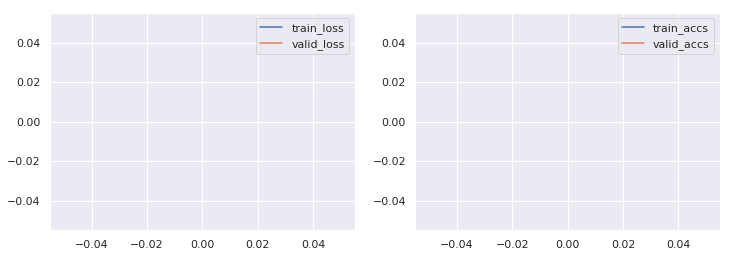

In [50]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(train_iter_index,reduced_train_lost,label='train_loss')
plt.plot(valid_iter_index, valid_loss, label='valid_loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_iter_index, reduced_train_accuracy, label='train_accs')
plt.plot(valid_iter_index, valid_accs, label='valid_accs')
plt.legend()
plt.show()

In [98]:
valid_iter = [i - 112 for i in valid_iter]

In [99]:
train_loss_red = []
little = []
compt = 1
for i in train_loss : 
    little.append(i)
    if compt%100 == 0:
        print(compt)
        train_loss_red.append(np.mean(little))
        little = []
    compt+=1

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000


In [100]:
np.mean(train_accs[:-100])

0.7038421

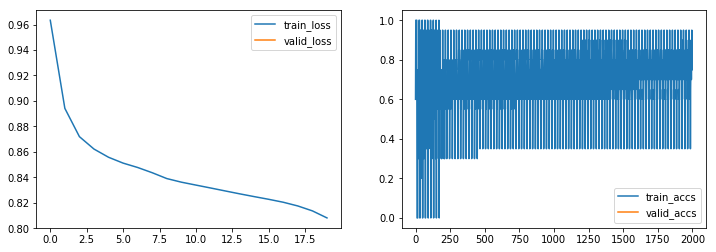

In [101]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_red, label='train_loss')
plt.plot(valid_iter, valid_loss, label='valid_loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='train_accs')
plt.plot(valid_iter, valid_accs, label='valid_accs')
plt.legend()
plt.show()


In [102]:
torch.max(output,1)[1]

tensor([1, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2],
       device='cuda:0')

In [356]:
net.eval()
val_losses, val_accs, val_lengths = 0, 0, 0
predictions = []
real_values = []
for val_batch in train_iter:
    output = net(val_batch.sequence)
    predictions += [int(i) for i in torch.max(output,1)[1]]
    real_values += [int(i) for i in val_batch.label]
    val_losses += criterion(output, val_batch.label)*val_batch.batch_size
    print(accuracy(output, val_batch.label) *val_batch.batch_size, val_batch.batch_size)
    val_accs += accuracy(output, val_batch.label) *val_batch.batch_size
    val_lengths += val_batch.batch_size

print("[%i]"%get_numpy(val_accs), val_lengths, val_accs)
# divide by the total accumulated batch sizes
val_losses /= val_lengths
val_accs /= val_lengths
valid_loss.append(get_numpy(val_losses))
valid_accs.append(get_numpy(val_accs))
print("[%i]"%get_numpy(val_accs))
net.train()

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:62: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor(15., device='cuda:0') 20
tensor(20., device='cuda:0') 20
tensor(17., device='cuda:0') 20
tensor(19., device='cuda:0') 20
tensor(20., device='cuda:0') 20
tensor(20., device='cuda:0') 20
tensor(20., device='cuda:0') 20
tensor(20., device='cuda:0') 20
tensor(20., device='cuda:0') 20
tensor(20., device='cuda:0') 20
tensor(19., device='cuda:0') 20
tensor(19., device='cuda:0') 20
tensor(19., device='cuda:0') 20
tensor(20., device='cuda:0') 20
tensor(19., device='cuda:0') 20
tensor(20., device='cuda:0') 20
tensor(20., device='cuda:0') 20
tensor(20., device='cuda:0') 20
tensor(20., device='cuda:0') 20
tensor(20., device='cuda:0') 20
[387] 400 tensor(387., device='cuda:0')
[0]


Net(
  (embeddings): Embedding(6, 100)
  (conv1): Conv1d(100, 100, kernel_size=(3,), stride=(3,))
  (lstm): LSTM(100, 111)
  (hidden2tag): Linear(in_features=111, out_features=3, bias=False)
)

In [357]:
predictions

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,


In [358]:
output

tensor([[8.3939e-07, 7.8227e-04, 9.9922e-01],
        [1.1353e-06, 7.3812e-05, 9.9993e-01],
        [8.5646e-06, 1.8252e-03, 9.9817e-01],
        [6.4346e-06, 3.1196e-03, 9.9687e-01],
        [2.4455e-04, 4.5467e-03, 9.9521e-01],
        [4.9675e-06, 8.7108e-04, 9.9912e-01],
        [1.5768e-05, 1.5943e-03, 9.9839e-01],
        [1.4948e-04, 2.4624e-03, 9.9739e-01],
        [1.3874e-05, 2.1734e-03, 9.9781e-01],
        [2.4438e-06, 5.0490e-05, 9.9995e-01],
        [3.6360e-06, 8.7438e-05, 9.9991e-01],
        [1.6291e-05, 2.7198e-03, 9.9726e-01],
        [1.5844e-05, 4.1070e-04, 9.9957e-01],
        [6.0377e-06, 1.4313e-03, 9.9856e-01],
        [7.8869e-06, 1.8403e-03, 9.9815e-01],
        [1.8819e-05, 1.8621e-03, 9.9812e-01],
        [1.2744e-05, 1.2774e-04, 9.9986e-01],
        [4.6169e-06, 4.3788e-03, 9.9562e-01],
        [1.7736e-05, 1.7656e-03, 9.9822e-01],
        [1.4403e-05, 8.0118e-05, 9.9991e-01]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)

In [359]:
from sklearn.metrics import confusion_matrix
import itertools

In [360]:


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()



Normalized confusion matrix
[[ nan  nan  nan]
 [0.01 0.97 0.02]
 [0.01 0.02 0.96]]


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


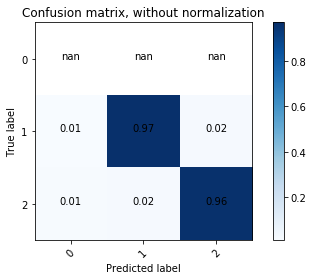

In [361]:
cnf_matrix = confusion_matrix(real_values, predictions)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
classes = [str(i) for i in range(NUM_CLASSES)]
plot_confusion_matrix(cnf_matrix, classes,
                      title='Confusion matrix, without normalization', normalize=True)


plt.show()
